Data Comes from this Source [Force Facies Classification Challenge 2020](https://xeek.ai/challenges/force-well-logs/data)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#@title Import relevant libraries
import numpy as np
import pandas as pd
import time

# Plotting packages
from matplotlib import pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
plt.style.use('seaborn-poster')
import plotly.express as px

# Machine learning Package
from sklearn.model_selection import train_test_split,learning_curve
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import StandardScaler

# %tensorflow_version 2.x
# from __future__ import absolute_import, division, print_function, unicode_literals
# import tensorflow as tf
# from tensorflow.keras import layers

# The following lines adjust the granularity of reporting 
pd.options.display.max_rows = 40
pd.options.display.float_format = "{:.2f}".format

print("Imported modules.")

Imported modules.


# Data Loading

In [ ]:
data = pd.read_csv("/content/drive/My Drive/FORCE/train.csv", sep = ';')

# Exploratory Data Analysis

In [ ]:
print('Data length: ' , len(data), 'observations')
print('Number of features: ' , data.columns.shape[0], 'logs')
print('Number of wells: ' , data['WELL'].unique().shape[0], 'wells')

Data length:  1170511 observations
Number of features:  29 logs
Number of wells:  98 wells


In [ ]:
logsname = pd.DataFrame(data.columns)
wells  = pd.DataFrame(data['WELL'].unique()) 

In [ ]:
data.sample(10)

,WELL,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,GROUP,FORMATION,CALI,RSHA,RMED,RDEP,RHOB,GR,SGR,NPHI,PEF,DTC,SP,BS,ROP,DTS,DCAL,DRHO,MUDWEIGHT,RMIC,ROPA,RXO,FORCE_2020_LITHOFACIES_LITHOLOGY,FORCE_2020_LITHOFACIES_CONFIDENCE
81875,16/10-3,881.75,460419.81,6453750.50,-841.72,NORDLAND GP.,NaN,20.05,0.80,0.79,1.06,nan,137.60,nan,nan,nan,147.99,509.18,17.50,27.71,nan,2.55,nan,0.15,nan,nan,nan,65000,1.00
249836,25/2-14,1599.00,476924.53,6625431.00,-1576.43,HORDALAND GP.,Grid Fm.,13.23,0.87,0.69,0.78,2.06,60.90,nan,nan,7.35,126.69,60.82,12.25,nan,nan,0.98,-0.00,nan,nan,nan,nan,65000,1.00
220431,25/11-19 S,1945.66,465915.22,6563680.50,-1778.44,ROGALAND GP.,Hermod Mb.,8.12,0.48,0.41,0.40,2.10,26.91,nan,0.31,2.02,110.55,nan,nan,30.87,nan,nan,-0.01,0.17,nan,nan,nan,30000,1.00
1126073,35/9-2,2194.33,550242.94,6800627.50,-2162.07,VIKING GP.,Fensfjord Fm.,8.30,8.58,41.33,59.18,2.29,86.93,96.95,0.26,nan,100.05,27.68,8.50,nan,163.04,-0.20,-0.01,nan,8.45,nan,9.57,65030,1.00
170050,16/7-5,537.82,446273.88,6468387.00,-511.01,NORDLAND GP.,NaN,19.14,1.17,1.15,1.47,nan,70.89,nan,nan,nan,170.09,26.92,nan,1.04,nan,nan,nan,1.07,nan,nan,nan,65000,1.00
279863,25/2-7,2756.83,479859.84,6641101.50,-2731.32,SHETLAND GP.,Vaale Fm.,12.36,19.70,19.70,12.69,2.63,19.32,nan,0.08,5.18,61.18,38.28,12.25,nan,nan,nan,-0.00,nan,nan,nan,nan,70000,1.00
299550,25/3-1,2422.99,487277.88,6643958.00,-2400.77,ROGALAND GP.,Vaale Fm.,16.23,nan,1.11,1.05,1.81,48.17,nan,nan,11.20,106.08,120.67,12.25,7.68,nan,3.94,0.02,1.80,nan,nan,nan,65000,1.00
329831,25/4-5,3964.74,454469.53,6603730.00,-3939.44,DUNLIN GP.,Statfjord Fm.,8.68,5.10,6.00,4.48,2.45,54.66,nan,0.16,nan,77.96,nan,8.50,nan,nan,0.18,-0.00,nan,5.10,nan,nan,65030,1.00
578456,31/2-8,1442.61,526928.88,6758510.50,-1417.55,ROGALAND GP.,Balder Fm.,17.92,nan,1.15,1.03,2.22,61.48,nan,0.46,nan,128.00,50.52,nan,nan,nan,nan,-0.00,nan,nan,nan,nan,99000,3.00
155403,16/4-1,2747.07,449957.78,6500259.00,-2721.12,ROTLIEGENDES GP.,Kupferschiefer Fm.,13.11,nan,3.20,7.42,2.55,73.59,nan,0.09,nan,62.63,98.33,12.25,13.57,nan,0.86,0.08,0.15,nan,nan,nan,30000,2.00


In [ ]:
data.describe()

,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,CALI,RSHA,RMED,RDEP,RHOB,GR,SGR,NPHI,PEF,DTC,SP,BS,ROP,DTS,DCAL,DRHO,MUDWEIGHT,RMIC,ROPA,RXO,FORCE_2020_LITHOFACIES_LITHOLOGY,FORCE_2020_LITHOFACIES_CONFIDENCE
count,1170511.00,1159736.00,1159736.00,1159736.00,1082634.00,630650.00,1131518.00,1159496.00,1009242.00,1170511.00,69353.00,765409.00,671692.00,1089648.00,864247.00,682657.00,535071.00,174613.00,298833.00,987857.00,316151.00,176160.00,192325.00,327427.00,1170511.00,1170332.00
mean,2184.09,485631.03,6681275.51,-2138.53,13.19,10.69,4.99,10.69,2.28,70.91,64.90,0.33,6.32,113.36,60.03,11.93,137.37,204.66,1.22,0.01,1.22,7.80,23.51,-95.78,61385.98,1.16
std,997.18,34556.41,128152.43,970.94,3.80,100.64,54.67,113.95,0.25,34.23,38.44,0.13,10.96,29.99,76.57,3.33,1539.38,71.07,54.37,7.48,10.18,89.74,22.63,348.98,13891.70,0.45
min,136.09,426898.78,6406641.00,-5395.56,2.34,0.00,-0.01,0.03,0.72,0.11,-777.99,-0.04,0.10,7.42,-999.00,6.00,-0.12,69.16,-12.22,-7429.34,0.13,0.06,-999.25,-999.90,30000.00,1.00
25%,1418.60,454799.56,6591327.00,-2811.50,9.43,0.85,0.91,0.91,2.09,47.63,42.96,0.24,3.41,87.83,32.40,8.50,5.63,155.94,0.15,-0.01,0.14,0.89,11.28,0.69,65000.00,1.00
50%,2076.61,476920.31,6737311.00,-2042.78,12.56,1.40,1.44,1.44,2.32,68.37,69.56,0.33,4.31,109.59,55.39,12.25,17.80,188.20,0.56,0.00,0.16,1.97,20.13,1.37,65000.00,1.00
75%,2864.39,520153.19,6784885.50,-1391.87,16.71,3.10,2.68,2.56,2.49,89.04,87.91,0.42,5.97,140.77,83.39,12.25,34.81,224.65,1.30,0.02,1.17,5.08,31.14,3.42,65000.00,1.00
max,5436.63,572632.75,6856661.00,-111.09,28.28,2193.90,1988.62,1999.89,3.46,1076.96,963.61,1.00,383.13,320.48,526.55,26.00,47015.12,676.58,10011.42,2.84,185.73,10000.00,742.80,35930.67,99000.00,3.00


## Get the well locations UTM style

In [ ]:
location = data[['WELL','X_LOC','Y_LOC']].drop_duplicates(subset=['WELL'])

In [ ]:
location.head(10)

,WELL,X_LOC,Y_LOC
0,15/9-13,437641.97,6470972.50
18270,15/9-15,436817.91,6462991.50
35987,15/9-17,438591.97,6478951.50
53337,16/1-2,455221.34,6533321.50
55071,16/1-6 A,459499.69,6539423.00
58694,16/10-1,444152.12,6435549.00
76369,16/10-2,443276.78,6444984.50
78806,16/10-3,460417.00,6453752.50
94762,16/10-5,448701.69,6429298.50
97527,16/11-1 ST3,474566.50,6436486.00


### Plotting wells relativelt to each other 

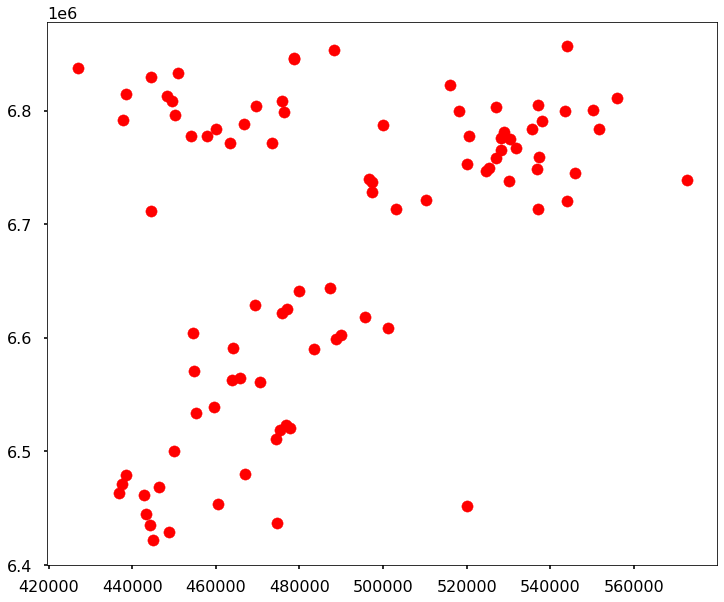

In [ ]:
plt.figure(figsize=(12,10))
plt.scatter(location['X_LOC'], location['Y_LOC'], label = location['WELL'], c='r' )


### Plotting wells relativelt to each other using plotly express

In [ ]:
fig1 = px.scatter(location, x=location['X_LOC'], y=location['Y_LOC'],
             title="Wells Relative Locations to UTM XY",
             hover_name = location['WELL'], text= location['WELL']
             )
fig1.update_xaxes(title_text='X_LOC')
fig1.update_yaxes(title_text='Y_LOC')

fig1.show()

### NA data Analysis

In [ ]:
nadata= pd.DataFrame(data.isna().sum())
nadata

,0
WELL,0
DEPTH_MD,0
X_LOC,10775
Y_LOC,10775
Z_LOC,10775
GROUP,1278
FORMATION,136994
CALI,87877
RSHA,539861
RMED,38993


#### Percentage of NA Data to the total 

In [ ]:
(nadata/len(data))*100

,0
WELL,0.00
DEPTH_MD,0.00
X_LOC,0.92
Y_LOC,0.92
Z_LOC,0.92
GROUP,0.11
FORMATION,11.70
CALI,7.51
RSHA,46.12
RMED,3.33


#### Plot NA data per log 

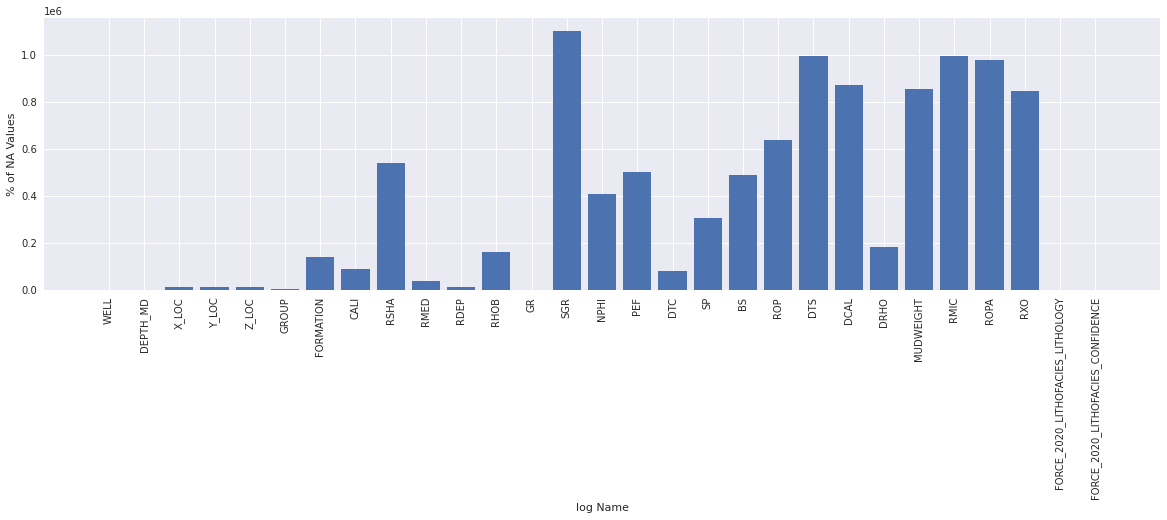

In [ ]:
with plt.style.context('seaborn'):
  plt.figure(figsize=(20,5))
  plt.bar(nadata.index, nadata[0] )
  plt.xticks(rotation = 90)
  plt.xlabel(xlabel = 'log Name')
  plt.ylabel("% of NA Values")
  plt.style.use('ggplot')
plt.show()

#### Plot NA data per log  using plotly express

In [ ]:
fig22 = px.bar(nadata, x=nadata.index, y=nadata[0]/10000,
             title="NA Percentages",
             color=nadata[0]/10000
             )
fig22.update_xaxes(title_text='Log names')
fig22.update_yaxes(title_text='NA %')

fig22.show()

In [ ]:
#@title NA as tables
from google.colab import data_table
data_table.DataTable((nadata/len(data))*100)


,0
WELL,0.00
DEPTH_MD,0.00
X_LOC,0.92
Y_LOC,0.92
Z_LOC,0.92
GROUP,0.11
FORMATION,11.70
CALI,7.51
RSHA,46.12
RMED,3.33


### Exporting One Well only to do modeling

In [ ]:
well1513 = data['WELL'] == '15/9-13'
well1513

0           True
1           True
2           True
3           True
4           True
           ...  
1170506    False
1170507    False
1170508    False
1170509    False
1170510    False
Name: WELL, Length: 1170511, dtype: bool

In [ ]:
well1513 = data[well1513]

In [ ]:
well1513.shape

(18270, 29)

#### Welldata Counts 

In [ ]:
WellCount = data['WELL'].value_counts()
WellCount = pd.DataFrame(WellCount)
WellCount

,WELL
25/2-7,25131
29/6-1,24464
25/7-2,23879
35/11-6,23544
34/2-4,23403
...,...
25/11-15,2284
34/5-1 S,2273
34/3-1 A,2251
7/1-2 S,2040


#### Well data Count Visualization

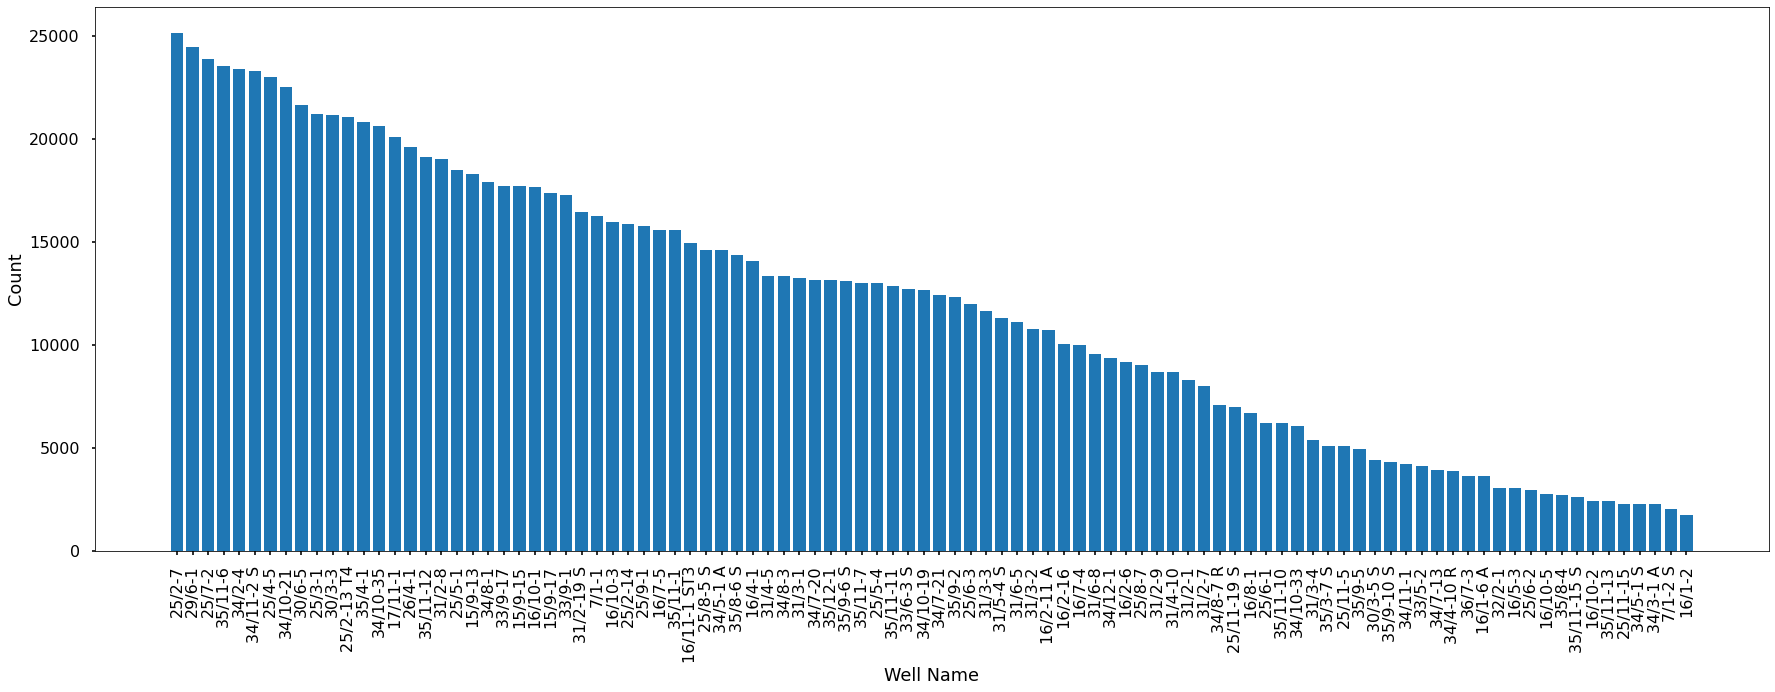

In [ ]:
plt.figure(figsize=(30,10))
plt.bar(WellCount.index, WellCount['WELL'] )
plt.xticks(rotation = 90)
plt.xlabel(xlabel = 'Well Name')
plt.ylabel("Count")
plt.show()


#### Exploring NA data percentage from the well 


In [ ]:
well1513na = pd.DataFrame(well1513.isna().sum()/len(well1513)*100)
#data_table.DataTable(a2na)

#### Plotting the NA Percentage % using plotly express

In [ ]:
fig22 = px.bar(well1513na, x=well1513na.index, y=well1513na[0],
             title="well1513 NA Percentages",
             color=well1513na[0]
             )
fig22.update_xaxes(title_text='Log names')
fig22.update_yaxes(title_text='well1513 NA %')

fig22.show()

#### Filter the logs with more  NA

In [ ]:
filtered_well1513 = well1513[['WELL', 'DEPTH_MD', 'X_LOC', 'Y_LOC', 'Z_LOC', 'CALI','RMED', 'RDEP', 'RHOB', 'GR','PEF',
       'DTC', 'SP','ROP','DRHO', 'MUDWEIGHT','FORCE_2020_LITHOFACIES_LITHOLOGY',
       'FORCE_2020_LITHOFACIES_CONFIDENCE']]

filtered_well1513.isna().sum()    

WELL                                    0
DEPTH_MD                                0
X_LOC                                   0
Y_LOC                                   0
Z_LOC                                   0
CALI                                    0
RMED                                    0
RDEP                                    0
RHOB                                    0
GR                                      0
PEF                                  1830
DTC                                    81
SP                                      0
ROP                                   109
DRHO                                    0
MUDWEIGHT                             806
FORCE_2020_LITHOFACIES_LITHOLOGY        0
FORCE_2020_LITHOFACIES_CONFIDENCE       0
dtype: int64

#### Remove all the NA's data observations

In [ ]:
NA_filtered_well1513= filtered_well1513.dropna(0,'any')
NA_filtered_well1513.shape

(15525, 18)

#### QC NA Removals

In [ ]:
NA_filtered_well1513.isna().sum() 

WELL                                 0
DEPTH_MD                             0
X_LOC                                0
Y_LOC                                0
Z_LOC                                0
CALI                                 0
RMED                                 0
RDEP                                 0
RHOB                                 0
GR                                   0
PEF                                  0
DTC                                  0
SP                                   0
ROP                                  0
DRHO                                 0
MUDWEIGHT                            0
FORCE_2020_LITHOFACIES_LITHOLOGY     0
FORCE_2020_LITHOFACIES_CONFIDENCE    0
dtype: int64

#### Data Modifications

In [ ]:
Xdata = NA_filtered_well1513.drop(columns=['WELL', 'FORCE_2020_LITHOFACIES_LITHOLOGY', 'FORCE_2020_LITHOFACIES_CONFIDENCE'])
ydata = NA_filtered_well1513['FORCE_2020_LITHOFACIES_LITHOLOGY']

lithology_numbers = {30000: 0,
                 65030: 1,
                 65000: 2,
                 80000: 3,
                 74000: 4,
                 70000: 5,
                 70032: 6,
                 88000: 7,
                 86000: 8,
                 99000: 9,
                 90000: 10,
                 93000: 11}

y = ydata.map(lithology_numbers)
y.sample(15)
#Xdata

8964     2
4916     2
11172    0
7426     2
16129    2
14125    5
7627     2
1398     2
2222     2
6087     2
14782    2
5488     2
2376     0
14216    3
15116    2
Name: FORCE_2020_LITHOFACIES_LITHOLOGY, dtype: int64

#### Scaling (Normalize) the data

In [ ]:
scaler = StandardScaler()
XScaled = scaler.fit_transform(Xdata)

#### Plot correlation matrix to show relations between features

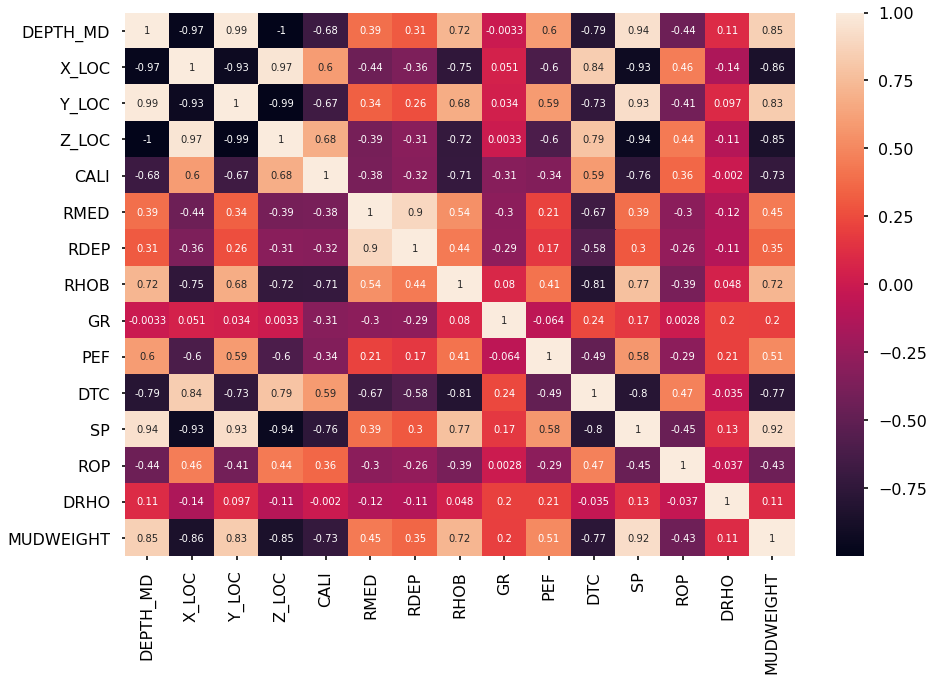

In [ ]:
plt.figure(figsize = (15,10))
sns.heatmap(Xdata.corr(),annot=True)

### Dataset Train Test split 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(Xdata, ydata, test_size=0.2, random_state=42)


## Features importance

In [ ]:
model = RandomForestClassifier(n_estimators=50, random_state=42, class_weight='balanced', oob_score=True, min_samples_leaf= 3)
model.fit(X_train, y_train)
y_pred_test = model.predict(X_test)
print('Model Score = {:.2f} '.format(model.score(X_test, y_test)))
print('Model Score = {:.2f} '.format(model.score(X_train, y_train)))


Model Score = 0.97 
Model Score = 0.99 


In [ ]:
# Feature Importance 

feature_imp = pd.Series(model.feature_importances_,index=Xdata.columns).sort_values(ascending=False)
feature_imp

GR          0.18
Z_LOC       0.15
DEPTH_MD    0.13
X_LOC       0.10
SP          0.08
Y_LOC       0.06
DTC         0.05
RDEP        0.04
CALI        0.04
RHOB        0.03
ROP         0.03
MUDWEIGHT   0.03
RMED        0.03
PEF         0.02
DRHO        0.01
dtype: float64

## Visualizing Important Features

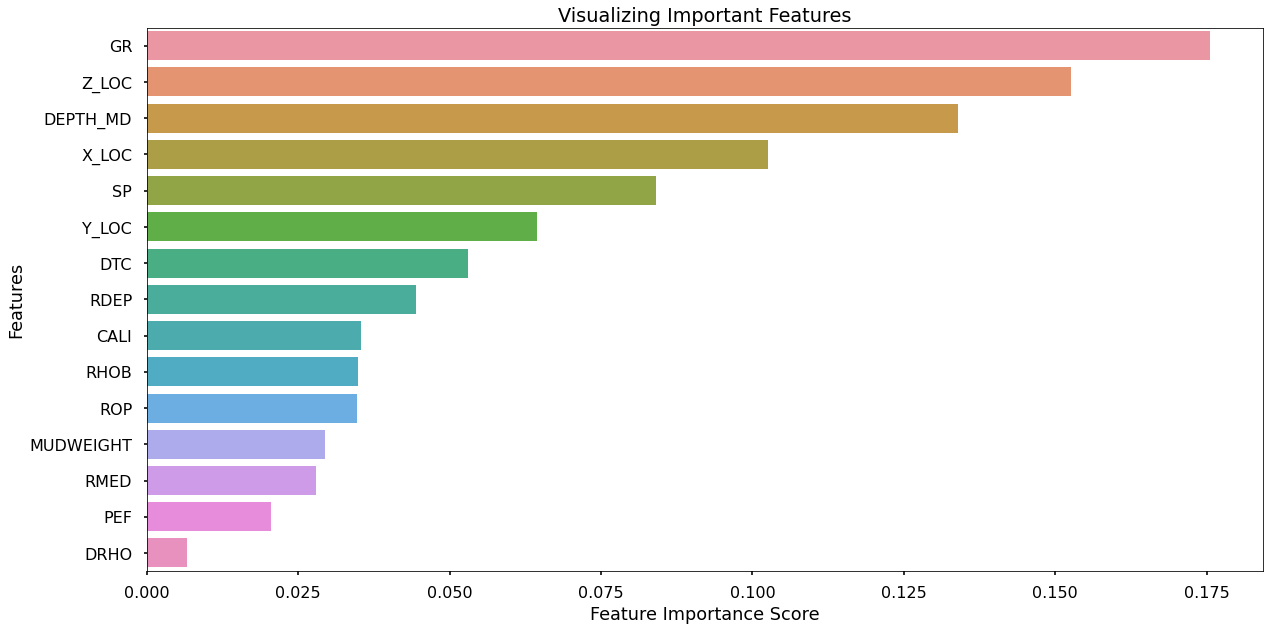

In [ ]:
#@title Visualizing Important Features
plt.figure(figsize=(20,10))
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
#plt.legend()
plt.show()

### Testing for overfitting using min sampling leaf

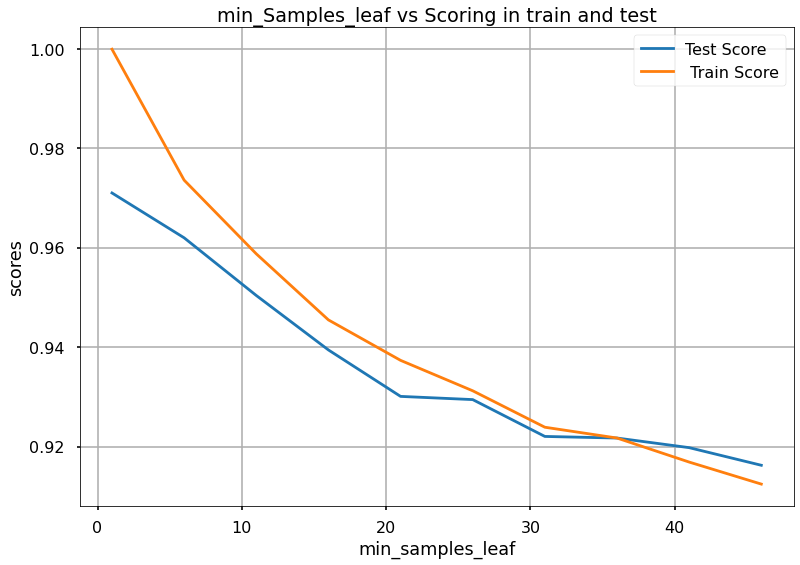

In [ ]:
scoringtest = []
scoringtrain = []
msamples =[]
for i in range(1,50,5):
  RfC = RandomForestClassifier(n_estimators=50, min_samples_leaf=i, max_features=0.5,class_weight='balanced', oob_score=True)
  RfC.fit(X_train,y_train)
  ht = RfC.score(X_test, y_test)
  h = RfC.score(X_train,y_train)
  #print(i, h, ht)
  scoringtest.append(ht)
  scoringtrain.append(h)
  msamples.append(i)
  
plt.plot(msamples, scoringtest)
plt.plot(msamples, scoringtrain)
plt.xlabel("min_samples_leaf")
plt.ylabel("scores")
plt.title('min_Samples_leaf vs Scoring in train and test')
plt.legend(['Test Score', ' Train Score'])
plt.grid()
plt.show()

## Using Random forest model

In [ ]:
RfC_model = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced', oob_score=True, min_samples_leaf= 5, max_features=1)
RfC_model.fit(X_train, y_train)
y_pred_test = RfC_model.predict(X_test)
print('Model Score = {:.2f} '.format(model.score(X_test, y_test)))
print('Model Score = {:.2f} '.format(model.score(X_train, y_train)))
print('OOB Score = {:.2f}'.format(RfC_model.oob_score_))

Model Score = 0.97 
Model Score = 0.99 
OOB Score = 0.95


In [ ]:
from sklearn.model_selection import cross_val_score

scores= cross_val_score(RfC_model,X_train,y_train, cv =5)
print('cross_val_score = {:.2f}'.format(scores.mean()))

cross_val_score = 0.95


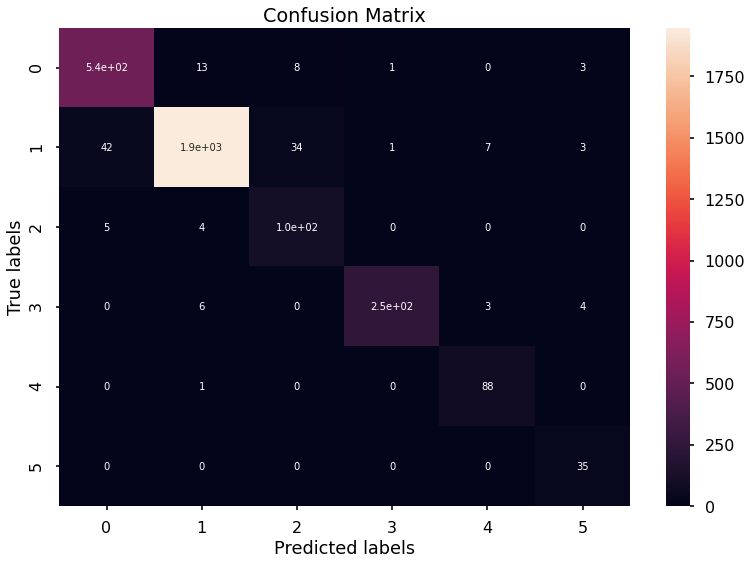

In [ ]:
from sklearn.metrics import confusion_matrix

RFC_Cm = confusion_matrix(y_test,y_pred_test)
ax= plt.subplot()
sns.heatmap(RFC_Cm, annot=True, ax = ax, cbar=True)

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
plt.show()

In [ ]:
## Metrics of ERRORS (Meaningless in this case)
print('Mean Absolute Error: {:.2f}'.format(metrics.mean_absolute_error(y_test, y_pred_test)) )
print('Mean Squared Error: {:.2f}' .format(metrics.mean_squared_error(y_test, y_pred_test)))
print('Root Mean Squared Error: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_test, y_pred_test))))

Mean Absolute Error: 976.34
Mean Squared Error: 34884813.49
Root Mean Squared Error: 5906.34


# Logistic regression


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, roc_auc_score

LR = LogisticRegression(max_iter= 200)
LR.fit(X_train, y_train)
LR_y_score = LR.predict_proba(X_train)
LR_y_predict = LR.predict(X_test)
#fpr, tpr, thresholds = roc_curve(ydata, LR_y_score)

Log Reg Accuracy 64.70 %:


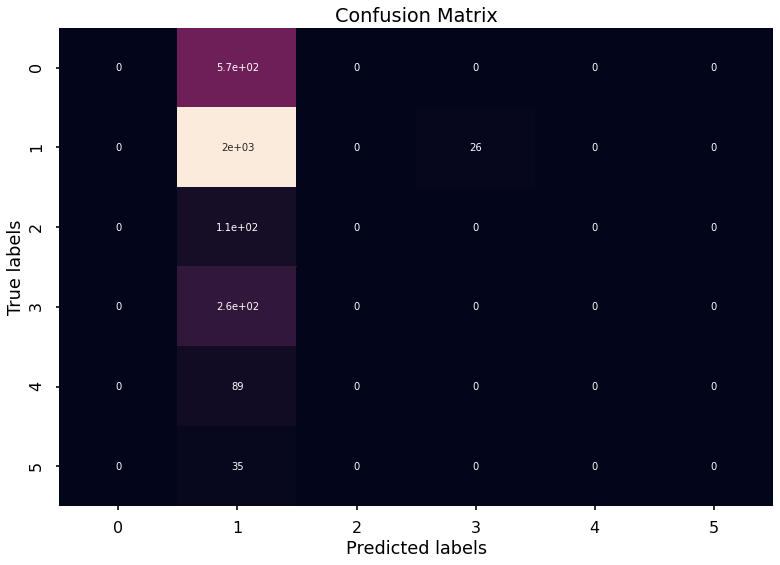

In [ ]:
LR_cm = confusion_matrix(y_true=y_test, y_pred=LR_y_predict)
print("Log Reg Accuracy {:.2f} %:". format(metrics.accuracy_score(y_test, LR_y_predict)*100))
ax= plt.subplot()
sns.heatmap(LR_cm, annot=True, ax = ax, cbar=False)

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
plt.show()

# SVM Classification

In [ ]:
from sklearn import svm
svc = svm.SVC(kernel='rbf').fit(X_train, y_train)
print("{:*^20s}".format("SVM Done")) 

******SVM Done******


SVM Accuracy 65.54 %:


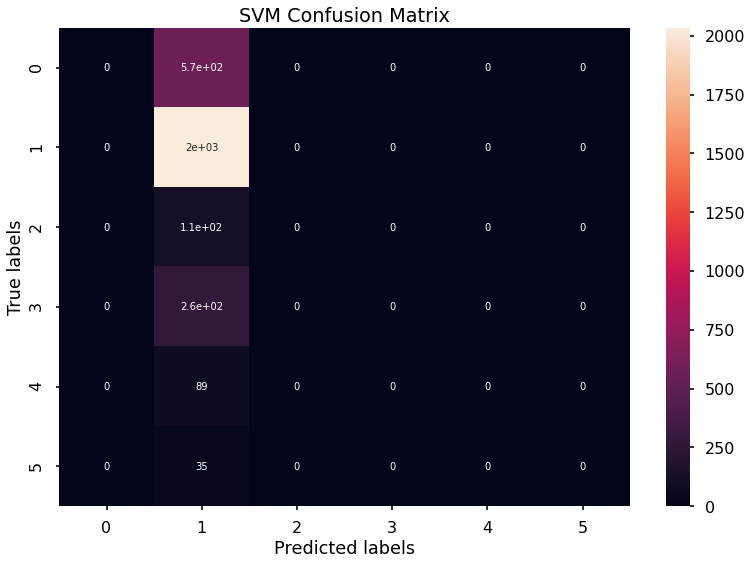

In [ ]:
y_pred_svm = svc.predict(X_test)
print("SVM Accuracy {:.2f} %:". format(metrics.accuracy_score(y_test, y_pred_svm)*100))

ax = plt.subplot()
svm_cm = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(svm_cm, ax = ax, annot=True)
# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('SVM Confusion Matrix')
plt.show()

**Pros and Cons associated with SVM**

**Pros:**
*   It works really well with a clear margin of separation
*   It is effective in high dimensional spaces.
*   It is effective in cases where the number of dimensions is greater than the number of samples.
*   It uses a subset of training points in the decision function (called support vectors), so it is also memory efficient.


**Cons:**

*   It doesn’t perform well when we have large data set because the required training time is higher
*   It also doesn’t perform very well, when the data set has more noise i.e. target classes are overlapping
*   VM doesn’t directly provide probability estimates, these are calculated using an expensive five-fold cross-validation. It is included in the related SVC method of Python scikit-learn library.


# Naive Bayes Algorithm 

Naive Bayes Accuracy: 75.01 % 


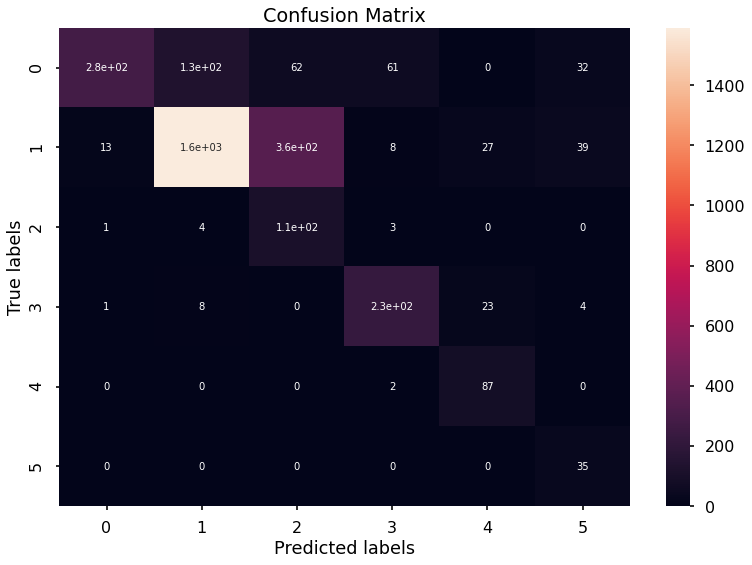

In [ ]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train, y_train, sample_weight= 1)
y_pred_gnb = gnb.predict(X_test)

print("Naive Bayes Accuracy: {:.2f} % ".format(metrics.accuracy_score(y_test, y_pred_gnb)*100))

ax = plt.subplot()
gnb_cm = confusion_matrix(y_test, y_pred_gnb)
sns.heatmap(gnb_cm, ax = ax, annot=True)
# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
plt.show()

**Advantages**

* It is not only a simple approach but also a fast and accurate method for prediction.
* Naive Bayes has very low computation cost.
* It can efficiently work on a large dataset.
* It performs well in case of discrete response variable compared to the continuous variable.
* It can be used with multiple class prediction problems.
* It also performs well in the case of text analytics problems.
* When the assumption of independence holds, a Naive Bayes classifier performs better compared to other models like logistic regression.

**Disadvantages**

* The assumption of independent features. In practice, it is almost impossible that model will get a set of predictors which are entirely independent.
* If there is no training tuple of a particular class, this causes zero posterior probability. In this case, the model is unable to make predictions. This problem is known as Zero Probability/Frequency Problem.



[Naive Bayes Classification](www.datacamp.com/community/tutorials/naive-bayes-scikit-learn)



# XGBOOST 
**Extreme Gradient Boost** 
[XGBOOST model using python](machinelearningmastery.com/develop-first-xgboost-model-python-scikit-learn/)



In [ ]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

xg = XGBClassifier(n_estimators= 500)
xg.fit(X_train, y_train)

y_pred_xg = xg.predict(X_test)
#the predictions made by XGBoost are probabilities.
#Because this is a binary classification problem, each prediction is the probability of the input pattern belonging to the first class.
#We can easily convert them to binary class values by rounding them to 0 or 1.
#predictions = [round(value) for value in y_pred_xg]

In [ ]:
# evaluate predictions
accuracy = accuracy_score(y_test, y_pred_xg)
print("XGBOOST Accuracy: %.2f%% " % (accuracy * 100.0))

xg_cm = confusion_matrix(y_true=y_test, y_pred=y_pred_xg)
xg_cm

XGBOOST Accuracy: 97.49% 


array([[ 546,   19,    2,    1,    0,    0],
       [  19, 2008,    6,    1,    0,    1],
       [   6,   10,   98,    0,    0,    0],
       [   1,    3,    0,  253,    1,    6],
       [   0,    2,    0,    0,   87,    0],
       [   0,    0,    0,    0,    0,   35]])

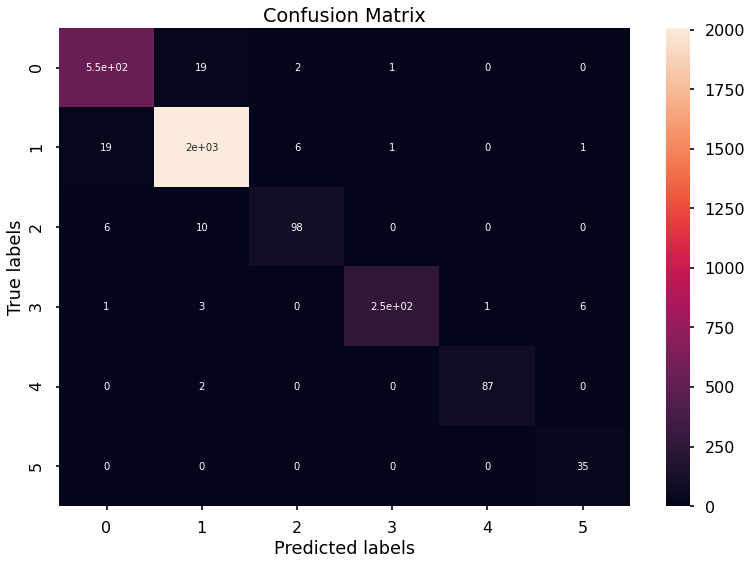

In [ ]:
ax= plt.subplot()
sns.heatmap(xg_cm, annot=True, ax = ax, cbar=True)

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
plt.show()

CPU time 4.52 min.


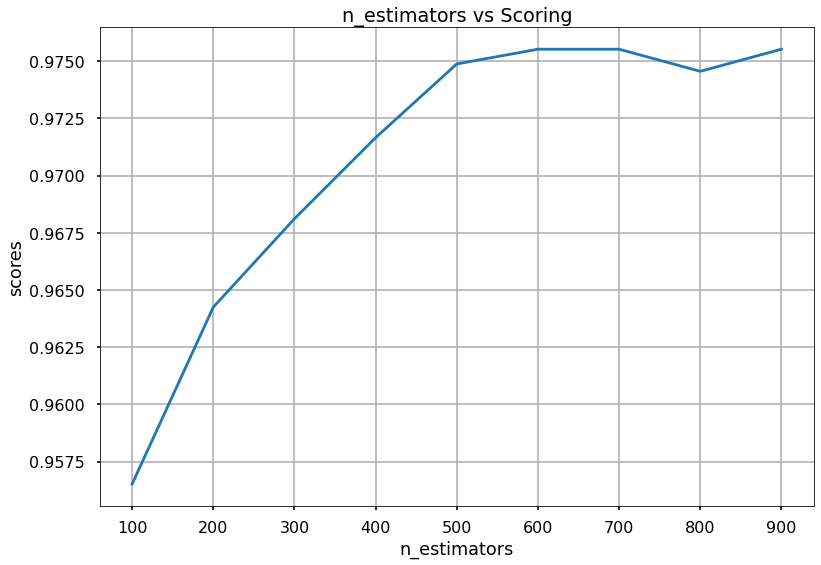

In [ ]:
start_pred_CPU = time.perf_counter()
msampl =[]
xgscore = []
for i in range(100,1000,100):
  xgt = XGBClassifier(n_estimators=i, loss = 'exponential')
  xgt.fit(X_train,y_train)
  xgth = xgt.score(X_test, y_test)
  xgscore.append(xgth)
  msampl.append(i)

total_pred_CPU = time.perf_counter() - start_pred_CPU
print("CPU time {:.2f} min.".format(total_pred_CPU/60)) 

plt.plot(msampl, xgscore)
plt.xlabel("n_estimators")
plt.ylabel("scores")
plt.title('n_estimators vs Scoring')
plt.grid()
plt.show()


In [ ]:
# Thanks to Brendon Hall 
# https://github.com/brendonhall/



def make_facies_log_plot(log_df, curves, facies_colors):
    
    #make sure logs are sorted by depth
    logs = log_df.sort_values(by='DEPTH_MD')
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.DEPTH_MD.min(); zbot=logs.DEPTH_MD.max()
    
    cluster=np.repeat(np.expand_dims(logs['LITH_LABEL'].values,1), 100, 1)
    
    num_curves = len(curves)
    f, ax = plt.subplots(nrows=1, ncols=num_curves+1, figsize=(num_curves*2, 12))
    
    for ic, col in enumerate(curves):
        
        # if the curve doesn't exist, make it zeros
        if np.all(np.isnan(logs[col])):
            curve = np.empty(logs[col].values.shape)
            curve[:] = np.nan
            
        else:
            curve = logs[col]
            
        ax[ic].plot(curve, logs['DEPTH_MD'])
        ax[ic].set_xlabel(col)
        ax[ic].set_yticklabels([]);

    # make the lithfacies column
    im=ax[num_curves].imshow(cluster, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=0,vmax=11)
    
    divider = make_axes_locatable(ax[num_curves])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im, cax=cax)
    cbar.set_label((12*' ').join(['  SS', 'SS-Sh', 'Sh', 
                                ' Ml', 'Dm', 'LS', 'Chk ', 
                                '  Hl', 'Ann', 'Tuf', 'Coal', 'Bsmt']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-1):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)

    ax[num_curves].set_xlabel('Facies')
    ax[num_curves].set_yticklabels([])
    ax[num_curves].set_xticklabels([])
    
    f.suptitle('Well: %s'%logs.iloc[0]['WELL'], fontsize=14,y=0.94)
    
    plt.show()

In [ ]:
lithology_keys = {30000: 'Sandstone',
                     65030: 'Sandstone/Shale',
                     65000: 'Shale',
                     80000: 'Marl',
                     74000: 'Dolomite',
                     70000: 'Limestone',
                     70032: 'Chalk',
                     88000: 'Halite',
                     86000: 'Anhydrite',
                     99000: 'Tuff',
                     90000: 'Coal',
                     93000: 'Basement'}

lithology_numbers = {30000: 0,
                 65030: 1,
                 65000: 2,
                 80000: 3,
                 74000: 4,
                 70000: 5,
                 70032: 6,
                 88000: 7,
                 86000: 8,
                 99000: 9,
                 90000: 10,
                 93000: 11}

In [ ]:
facies_color_map = { 'Sandstone': '#F4D03F',
                     'Sandstone/Shale': '#7ccc19',
                     'Shale': '#196F3D',
                     'Marl': '#160599',
                     'Dolomite': '#2756c4',
                     'Limestone': '#3891f0',
                     'Chalk': '#80d4ff',
                     'Halite': '#87039e',
                     'Anhydrite': '#ec90fc',
                     'Tuff': '#FF4500',
                     'Coal': '#000000',
                     'Basement': '#DC7633'}

facies_color_map1 = { 30000: '#F4D03F',
                     65030: '#7ccc19',
                     65000: '#196F3D',
                     80000: '#160599',
                     74000: '#2756c4',
                     70000: '#3891f0',
                     70032: '#80d4ff',
                     88000: '#87039e',
                     86000: '#ec90fc',
                     99000: '#FF4500',
                     90000: '#000000',
                     93000: '#DC7633'}

# get a list of the color codes.
facies_colors = [facies_color_map[mykey] for mykey in facies_color_map.keys()]
facies_colors2 = [facies_color_map1[mykey] for mykey in facies_color_map1.keys()]